# <center>James Web Telescope Images GAN</center>
<center>by Nigel Story</center>

---

## Contents <a class='anchor' id='contents'></a>

* [1. Introduction](#introduction)
    * [1.1 Packages and Setup](#packages-and-setup)
* [2. Creating Training Images](#create-training-images)
* [3. Reading in Dataset](#read-in-dataset)
* [4. Defining the Model](#defining-the-model)
    * [4.1 The Discriminator](#the-discriminator)
    * [4.2 The Generator](#the-generator)
* [5. Training](#training)
* [6. Results](#results)
* [7. Conclusion](#conclusion)

## Introduction <a class='anchor' id='introduction'></a>

NASA recently released the first images taken by the <a href='https://webb.nasa.gov/' target='_blank'>James Webb Telescope</a>, and the world was amazed. The orbiting telescope was first launched on December 25, 2021, and images were released to the public on July 12, 2022. It is the most advanced telescope launched by humans to date, taking photographs of the furthest galaxies ever seen along with beautifully detailed images of distant nebulae and stars.

But who needs that when you can make up those kinds of pictures with AI? Kidding, of course, but it would be magical to be able to create your own small snapshot of space. That's where the GAN comes in.

### About the Model <a class='anchor' id='about-the-model'></a>

The Generative Adversarial Network (GAN) is a deep-learning neural network that can be trained to generate data, in our case images, that do not actually exist. The way a GAN works is by pitting two models against each other: one to generate synthetic data, and the other to discriminate between the synthetic data and real data. Together, these to "adversaries" working agaist each other result in a generator that can produce synthetic data that looks real enough to trick the discriminator and perhaps even a human.

For our model, the real data will be 64x64 subsets of the images taken by the James Webb Telescope.

### Packages and Setup <a class='anchor' id='packages-and-setup'></a>

In [1]:
import os
import math
import numpy as np
import time
from PIL import Image
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
data_path = '/Users/nigelstory/Documents/jw_training_images/'
snippets_path = '/Users/nigelstory/Documents/jw_image_snippets/'
model_path = '/Users/nigelstory/Documents/jw_gan_models/'

In [3]:
full_image_files = [x for x in os.listdir(data_path) if x.endswith('.tif')]
full_image_files

['deep_field.tif',
 'southern_ring_nebula.tif',
 'cosmic_cliffs.tif',
 'stephan_quintet.tif']

## Creating Training Images <a class='anchor' id='create-training-images'></a>

The full-sized images from the telescope are quite large -- over 4000x4000 -- which is too big to processed all at once, so we will scan each image and extract 512x512 squares from each, which is big enough to capture some interesting features of the photos, and then the images will be downsized to 64x64.

In [4]:
img = Image.open(data_path + full_image_files[0])

In [5]:
img_arr = np.array(img)
img_arr.shape

(4630, 4537, 3)

In [6]:
stride = 512

In [7]:
snippets = np.lib.stride_tricks.sliding_window_view(img_arr, (stride, stride, 3))

The shape of the resulting array conveys the following meaning:
* The first two dimensions are the dimensions of the origin image, and are the indices over which the window has iterated. These are described by shape\[:2\]
* Each iteration produced one image. This is shape\[2\].
* Each image is a (stride, stride, 3) color image. Our stride is 512. This is represented in shape\[3:\]

So overall, the shape of `snippets` represents the following: <br>
`(number of vertical steps, number of horizontal steps, number of images produced per step, vertical dimension of output image, horizontal dimension of output image, color channels)`

In [8]:
snippets.shape

(4119, 4026, 1, 512, 512, 3)

In [9]:
tst = snippets[0][0][0]

Below, we can see one of the 512x512 extracted "snippets." This will be downsized futher to 64x64.

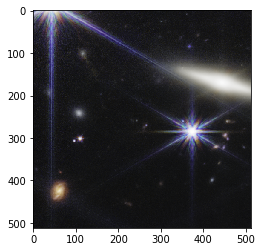

In [10]:
plt.imshow(tst)
plt.show()

And below, we see the same example at its final 64x64 resolution.

In [11]:
small_tst = Image.fromarray(tst).resize((64, 64), Image.ANTIALIAS)

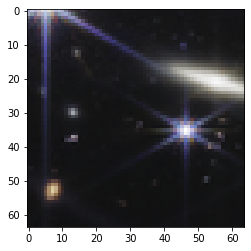

In [12]:
plt.imshow(small_tst)
plt.show()

In order to loop through the snippet images, we need to loop through the indices of the first two dimensions of `snippets` with the third dimension taken at 0. This will yield the arrays representing the (64, 64, 3) color image snippets.

In [13]:
def get_snippets(image_file, output_path, stride=512):
    """Create (stride, stride, 3) color image snippets from
    larger image file.
    
    Args:
        image_file (str): Name of image file from which to create snippets.
        output_path (str): Path to which snippets are to be saved.
        stride (int): Shape of square snippet. Also governs the stride taken
            between snippet recordings.
            
    Returns:
        None
    """
    
    img_name_idx = len(os.listdir(output_path))
    
    img = Image.open(data_path + image_file)
    img_arr = np.array(img)
    snippets = np.lib.stride_tricks.sliding_window_view(img_arr, (stride, stride, 3))
    
    bounds = snippets.shape[:2]
    
    for i in range(0, bounds[0], stride):
        for j in range(0, bounds[1], stride):
            snippet_arr = snippets[i][j][0]
            out_img = Image.fromarray(snippet_arr).resize((64, 64), Image.ANTIALIAS)
            out_img.save(output_path + f"{img_name_idx}.png")
            img_name_idx += 1

We then save the final snippets to a training directory that we can use with PyTorch's image loader. This will provide us with 390 training images.

In [14]:
# for f in tqdm(full_image_files):
#     get_snippets(f, snippets_path + 'train/1/')

## Reading in the Dataset <a class='anchor' id='read-in-the-dataset'></a>

In [15]:
img_size = 64
batch_size = 128

In [16]:
# create image transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    # shift data range to (-1, 1)
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])

In [17]:
dataset = torchvision.datasets.ImageFolder(
    snippets_path,
    transform=transform
)

data_loader = torch.utils.data.DataLoader(
    dataset=dataset,
    batch_size=batch_size,
    shuffle=True
)

In [18]:
# set gpu or cpu
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


## Defining the Model <a class='anchor' id='defining-the-model'></a>

The GAN model is composed of two component models: the generator and the discriminator. The better these two models perform, the better your generated data will be. For our models, we will use a Convolutional Neural Network as our discriminator and a decoding feed-forward neural network for our generator.

### The Discriminator <a class='anchor' id='the-descriminator'></a>

In [19]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()   
        
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2)
        )
        
        self.conv_layers2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),
            nn.Flatten()
        )

        self.dense_layers = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256*8*8, 1024),
            nn.LeakyReLU(0.2),
            
            nn.Dropout(0.2),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            
            nn.Linear(512, 1)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.conv_layers2(x)
        x = self.dense_layers(x)

        return x

### The Generator <a class='anchor' id='the-generator'></a>

The generator model takes as input random noise and outputs its generated data. The higher dimensionality used as input noise, the more granular your generated data will be. That is because the noise is representative of the latent space of the model, or the space from which the model can select its synthetic data. The trade-off is that the higher the dimension you use for the latent space, the larger your generator neural network will have to be and the longer the model will take to converge. After experimentation, 100 dimensions yields the best results for our uses.

The architecture of our generator is a feed-forward network, taking 100 features as input (noise) and outputting a vector the same length as a flattened image from our training images (64\*64\*3). This works similarly to the back half, or decoding layers, of an autoencoder.

In [20]:
class GAN(nn.Module):
    
    def __init__(self):
        super(GAN, self).__init__()
        
        # discriminator
        self.D = CNN()
        
        # generator
        self.latent_dim = 100
        self.G = nn.Sequential(
            nn.Linear(self.latent_dim, 256),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(256, momentum=0.7),
            
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(512, momentum=0.7),
            
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(1024, momentum=0.7),
            
            nn.Linear(1024, 2048),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(2048, momentum=0.7),
            
            nn.Linear(2048, 4096),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(4096, momentum=0.7),
            
            nn.Linear(4096, img_size*img_size*3),
            nn.Tanh()
        )
        
    def forward(self):
        pass

## Training <a class='anchor' id='training'></a>

Now it's time to train the model. We will start with 150 epochs, with batch sizes of 128.

The model will first train the discriminator with a batch of real images and a batch of noise generated by the untrained generator model. The discriminator will then undergo backpropagation, which will reinforce its ability to distinguish between generated data and the real images.

Next we train the generator. After the discriminator has trained once, the generator will generate a new batch of images and feed them to the discriminator. The discriminator will produce predictions, identifying some of the generated images as fake. Since the generator wants all of its outputs to be identified as true, we calculate the loss and backpropagate as though we had true values for all of out prediction targets. This will iteratively train the generator to produce images that the discriminator will think are real images.

In [21]:
def scale_image(img):
    # scale images back to (0, 1)
    out = (img + 1) / 2
    return out


def batch_train(model, criterion, optimizers, data_loader, batch_size, epochs=10):
    # label placeholders
    ones_ = torch.ones(batch_size).to(device)
    zeros_ = torch.zeros(batch_size).to(device)
    
    # optimizers
    g_optimizer = optimizers[0]
    d_optimizer = optimizers[1]
    
    # losses (not necessary)
    g_losses = []
    d_losses = []
    
    for epoch in range(epochs):
        start_time = time.time()
        for inputs,_ in data_loader:
            inputs = inputs.to(device)
            n = inputs.size(0)
            ones = ones_[:n].unsqueeze(1)
            zeros = zeros_[:n].unsqueeze(1)
            
            g_optimizer.zero_grad()
            d_optimizer.zero_grad()
            
            ### Train Discriminator
            # real images
            real_outputs = model.D(inputs)
            d_loss_real = criterion(real_outputs, ones)
            
            # fake images
            noise = torch.randn(n, model.latent_dim).to(device)
            fake_images = model.G(noise)
            fake_images = fake_images.reshape(n, 3, img_size, img_size)
            fake_outputs = model.D(fake_images)
            d_loss_fake = criterion(fake_outputs, zeros)
            
            d_loss = (d_loss_real + d_loss_fake) / 2
            
            d_loss.backward()
            d_optimizer.step()
            
            ### Train Generator (x2)
            for _ in range(2):
                d_optimizer.zero_grad()
                g_optimizer.zero_grad()
                
                noise = torch.randn(n, model.latent_dim).to(device)
                fake_images = model.G(noise)
                fake_images = fake_images.reshape(n, 3, img_size, img_size)
                fake_outputs = model.D(fake_images)
                
                g_loss = criterion(fake_outputs, ones) # fake images as real
                
                g_loss.backward()
                g_optimizer.step()
            
            g_losses.append(g_loss.item())
            d_losses.append(d_loss.item())
                
        print(f"Epoch {epoch+1}/{epochs}: d_loss={d_loss.item():0.4f}, g_loss={g_loss.item():0.4f}," + \
              f" elapsed_time={time.time()-start_time:0.2f}s")
            
        fake_images = fake_images.reshape(-1, 3, img_size, img_size)
        save_image(scale_image(fake_images), f"/Users/nigelstory/Documents/jw_generated_images/epoch_{epoch+1}.png")
            
    return g_losses, d_losses

In [22]:
model = GAN()
model.to(device)

GAN(
  (D): CNN(
    (conv_layers): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.2)
      (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): LeakyReLU(negative_slope=0.2)
      (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (conv_layers2): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.2)
      (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): LeakyReLU(negative_slope=0.2)
      (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats

In [23]:
criterion = nn.BCEWithLogitsLoss()
g_optimizer = torch.optim.Adam(model.G.parameters(), lr=0.0002, betas=(0.5, 0.999))
d_optimizer = torch.optim.Adam(model.D.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [91]:
losses = batch_train(model, criterion, (g_optimizer, d_optimizer), data_loader, batch_size, epochs=150)

Epoch 1/150: d_loss=1.0122, g_loss=1.4784, elapsed_time=23.80s
Epoch 2/150: d_loss=0.0001, g_loss=8.1683, elapsed_time=23.11s
Epoch 3/150: d_loss=0.0190, g_loss=5.7589, elapsed_time=22.80s
Epoch 4/150: d_loss=0.0106, g_loss=6.9010, elapsed_time=23.15s
Epoch 5/150: d_loss=0.0022, g_loss=6.2908, elapsed_time=22.89s
Epoch 6/150: d_loss=0.0081, g_loss=12.9904, elapsed_time=22.84s
Epoch 7/150: d_loss=0.0003, g_loss=14.4401, elapsed_time=22.94s
Epoch 8/150: d_loss=0.0003, g_loss=10.7444, elapsed_time=22.84s
Epoch 9/150: d_loss=0.0034, g_loss=6.1920, elapsed_time=22.86s
Epoch 10/150: d_loss=0.0142, g_loss=6.9884, elapsed_time=22.96s
Epoch 11/150: d_loss=0.0004, g_loss=8.5730, elapsed_time=23.05s
Epoch 12/150: d_loss=0.0045, g_loss=6.3211, elapsed_time=23.49s
Epoch 13/150: d_loss=0.0024, g_loss=8.9670, elapsed_time=23.32s
Epoch 14/150: d_loss=0.0060, g_loss=9.3731, elapsed_time=23.18s
Epoch 15/150: d_loss=0.0025, g_loss=8.4484, elapsed_time=22.98s
Epoch 16/150: d_loss=0.0032, g_loss=9.6658, el

KeyboardInterrupt: 

## Results <a class='anchor' id='results'></a>

We trained the model for 386 epochs, ending with a model that produces fairly nice images. Early stopping criteria for GAN models is something that is still actively being researched, and is something I plan to explore in future projects, but for now, we simply stopped trainig when the output images looked good to the human eye.

In [119]:
def generate_image(model):
    """Generate a random image from a GAN's generator model.
    
    Args:
        model (nn.Module): GAN model with which to generate image.
        
    Returns:
        PIL.Image: Generated image.
    """
    
    model.G.eval()
    rand_vec = torch.randn(1, model.latent_dim).to(device)
    output_image = model.G(rand_vec)
    
    output_image = output_image.reshape(3, 64, 64)
    output_image = scale_image(output_image)
    transform = transforms.ToPILImage()
    output_image = transform(output_image)
    output_image = output_image.resize((512, 512), Image.ANTIALIAS)
    
    return output_image
    

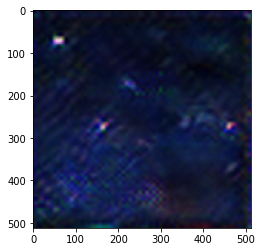

In [124]:
img = generate_image(model)
img = np.array(img)

plt.figure(figsize=(4,4))
plt.imshow(img)
plt.show()

In [113]:
# torch.save(model.G, model_path + 'gan_2.torch')

## Conclusion <a class='anchor' id='conclusion'></a>

Our GAN produces some nice looking, if a bit grainy, synthetic images of space. I am suprised that the model did not pick up more on the classic hexagon artifacts that we see in the real images from the James Webb Telescope. I believe this is because in the larger training data, these artifacts were not as common as one would think.

I was also suprised by the number of feasible models were produced in passing during the training process, highlighting how difficult defining an early stopping citerion can be for GANs. In future projects, I plan to explore criteria, such as inception scores, that could provide more objectivity when it comes to terminating training. 